# Initial codes

In [ ]:
# Install required libraries
!pip install scikit-image torchmetrics
!pip install --upgrade torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.3 MB/s eta 0:00:00


In [ ]:
# Required libraries
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchvision.transforms import ToTensor, Normalize, Compose
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os

# Run on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Mounting drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip dataset
os.makedirs(f'/content/drive/MyDrive/emotions', exist_ok=True)
!unzip -q "/content/drive/MyDrive/emotions.zip" -d "/content/emotions"

# **2.**

In [ ]:
def add_salt_and_pepper_noise(image, prob=0.1):
    noisy_image = image.copy()

    # Add salt noise
    num_salt = np.ceil(prob * image.size)
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
    noisy_image[tuple(coords)] = 1.0

    # Add pepper noise
    num_pepper = np.ceil(prob * image.size)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
    noisy_image[tuple(coords)] = 0.0

    return noisy_image

data = pd.read_csv('/content/emotions/fer2013.csv')
pixels = data['pixels']

os.makedirs('/content/emotions_original', exist_ok=True)
os.makedirs('/content/emotions_noisy', exist_ok=True)

img_size = (48, 48)

for idx, pixel_data in enumerate(pixels):
    # Convert pixel data to 2D image
    img_array = np.array(pixel_data.split(), dtype=np.float32).reshape(img_size) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension for grayscale

    # Add salt-and-pepper noise
    img_array_noisy = add_salt_and_pepper_noise(img_array[:, :, 0])  # Remove channel dimension for noise function
    img_array_noisy = np.expand_dims(img_array_noisy, axis=-1)  # Add back channel dimension

    original_img = array_to_img(img_array)
    noisy_img = array_to_img(img_array_noisy)

    original_img.save(os.path.join('/content/emotions_original', f"{idx}.png"))
    noisy_img.save(os.path.join('/content/emotions_noisy', f"{idx}.png"))

print('Images saved to:\n/content/emotions_original\n/content/emotions_noisy')

Images saved to:
/content/emotions_original
/content/emotions_noisy


In [ ]:
# Load dataset
class FER2013Dataset(Dataset):
    def __init__(self, original_dir, noisy_dir, transform=None):
        self.original_dir = original_dir
        self.noisy_dir = noisy_dir
        self.transform = transform
        self.image_ids = sorted(os.listdir(original_dir))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        original_path = os.path.join(self.original_dir, self.image_ids[idx])
        noisy_path = os.path.join(self.noisy_dir, self.image_ids[idx])

        original_img = Image.open(original_path).convert('RGB')  # Convert grayscale to RGB
        noisy_img = Image.open(noisy_path).convert('RGB')

        if self.transform:
            original_img = self.transform(original_img)
            noisy_img = self.transform(noisy_img)

        return noisy_img, original_img

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images to [-1, 1]
])

dataset = FER2013Dataset('/content/emotions_original', '/content/emotions_noisy', transform=transform)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

batch_size = 32
noisy_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
noisy_validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, padding=padding),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(out_channels, out_channels, size, padding=padding, stride=stride),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        # x size = (batch_size, channel, width, height)
        x = self.convs(x)
        return x

class DeConv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2):
        super().__init__()
        self.deConv = nn.ConvTranspose2d(in_channels, out_channels, size,
                                         padding=1, stride=2, output_padding=1)
        self.convs = Conv_block(out_channels * 2, out_channels, size, padding, dropout)

    def forward(self, x, residual):
        # x size = (batch_size, channel, width, height)
        x = self.deConv(x)
        x = torch.cat([x, residual], 1)
        x = self.convs(x)
        return x

class Unet(nn.Module):
    def __init__(self, d=64, out_channels=3, dropout=0.2):
        super().__init__()

        # Unet encoder
        self.conv_blocks = nn.ModuleList([
            Conv_block(3, d, dropout=dropout),
            Conv_block(d, 2 * d, stride=2, dropout=dropout),
            Conv_block(2 * d, 4 * d, stride=2, dropout=dropout),
            Conv_block(4 * d, 8 * d, stride=2, dropout=dropout),
            Conv_block(8 * d, 16 * d, stride=2, dropout=dropout)
        ])

        # Unet decoder
        self.deConv_blocks = nn.ModuleList([
            DeConv_block(16 * d, 8 * d, dropout=dropout),
            DeConv_block(8 * d, 4 * d, dropout=dropout),
            DeConv_block(4 * d, 2 * d, dropout=dropout),
            DeConv_block(2 * d, d, dropout=dropout),
        ])

        self.output_conv = nn.Conv2d(d, out_channels, 3, padding=1)
        self.float()

    def forward(self, x):
        x1 = self.conv_blocks[0](x)
        x2 = self.conv_blocks[1](x1)
        x3 = self.conv_blocks[2](x2)
        x4 = self.conv_blocks[3](x3)
        x5 = self.conv_blocks[4](x4)

        x = self.deConv_blocks[0](x5, x4)
        x = self.deConv_blocks[1](x, x3)
        x = self.deConv_blocks[2](x, x2)
        x = self.deConv_blocks[3](x, x1)

        x = self.output_conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, label_channels=3, input_channels=3, d=64):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(label_channels + input_channels, d, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d),

            nn.Conv2d(d, d*2, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*2),

            nn.Conv2d(d*2, d*4, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*4),

            nn.Conv2d(d*4, d*8, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*8),

            nn.Conv2d(d*8, 1, 3, 2, 1),
        )
        self.float()

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.convs(x)
        return x

In [ ]:
generator = Unet()
discriminator = Discriminator()
model = nn.ModuleDict({'generator': generator, 'discriminator': discriminator})

generator_l2_loss = nn.MSELoss()
geratator_gan_loss = nn.BCEWithLogitsLoss()
discriminator_gan_loss = nn.BCEWithLogitsLoss()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 5
lam = 100
valid_loss_min = np.Inf
model.to(device)
history = {'train': [], 'valid': []}

if os.path.exists('GAN-UNET-Checkpoint.pth'):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    history = checkpoint['history']
    print(f'Resuming training.')
else:
    print('No checkpoint found. Starting training from scratch.')

for i in range(epoch):
    model.train()
    sum_train_mse = 0
    training_steps = 0
    for x, y in tqdm(noisy_train_loader):

        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        D_result_real = model['discriminator'](x, y).squeeze().float()
        D_real_loss = discriminator_gan_loss(D_result_real, torch.zeros(D_result_real.size(), device=device))

        with torch.no_grad():
            G_result = model['generator'](x).float()
        D_result_fake = discriminator(x, G_result).squeeze().float()
        D_fake_loss = discriminator_gan_loss(D_result_fake, torch.ones(D_result_fake.size(), device=device))
        D_train_loss = (D_real_loss + D_fake_loss) * 0.5

        D_train_loss.backward()
        discriminator_optimizer.step()

        G_result = model['generator'](x).float()
        D_result_fake = model['discriminator'](x, G_result).squeeze().float()
        G_gan_loss = geratator_gan_loss(D_result_fake, torch.zeros(D_result_fake.size(), device=device))
        G_mse_loss = generator_l2_loss(G_result, y)
        G_train_loss = G_gan_loss + G_mse_loss * lam

        G_train_loss.backward()
        generator_optimizer.step()

        sum_train_mse += G_mse_loss.cpu().item()
        training_steps += 1

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for x, y in tqdm(noisy_validation_loader):
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model['generator'](x)
        loss = criterion(output, y)

        valid_loss = loss.cpu().item()
        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'GAN-UNET-0.07.pt')
        valid_loss_min = valid_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'generator_optimizer_state_dict': generator_optimizer.state_dict(),
            'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
            'history': history,
        }, 'GAN-UNET-Checkpoint.pth')

    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1}, Train MSE: {sum_train_mse / training_steps:.6f}, Validation MSE: {sum_valid_mse / valid_steps:.6f}')

<ipython-input-40-9816280db2df>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training.


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1, Train MSE: 0.012178, Validation MSE: 0.009697


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2, Train MSE: 0.012095, Validation MSE: 0.009725


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3, Train MSE: 0.012267, Validation MSE: 0.009550


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4, Train MSE: 0.012035, Validation MSE: 0.010876


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5, Train MSE: 0.012543, Validation MSE: 0.010722


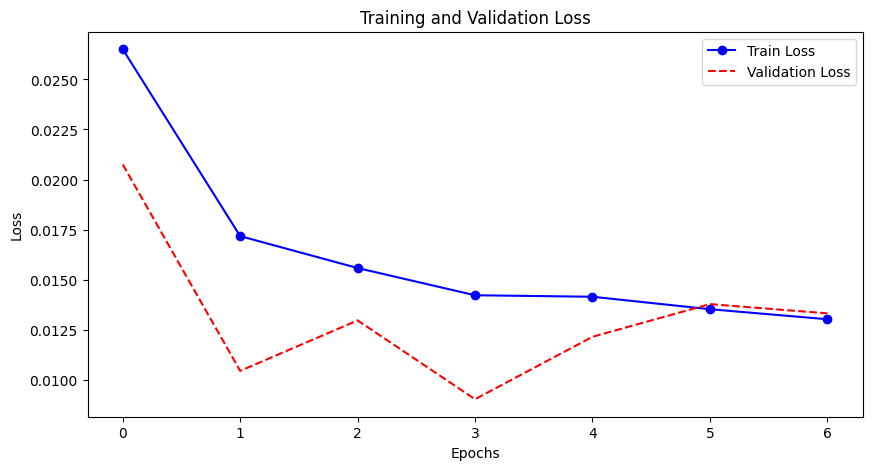

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['train'], 'bo-', label='Train Loss')
plt.plot(history['valid'], 'r--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

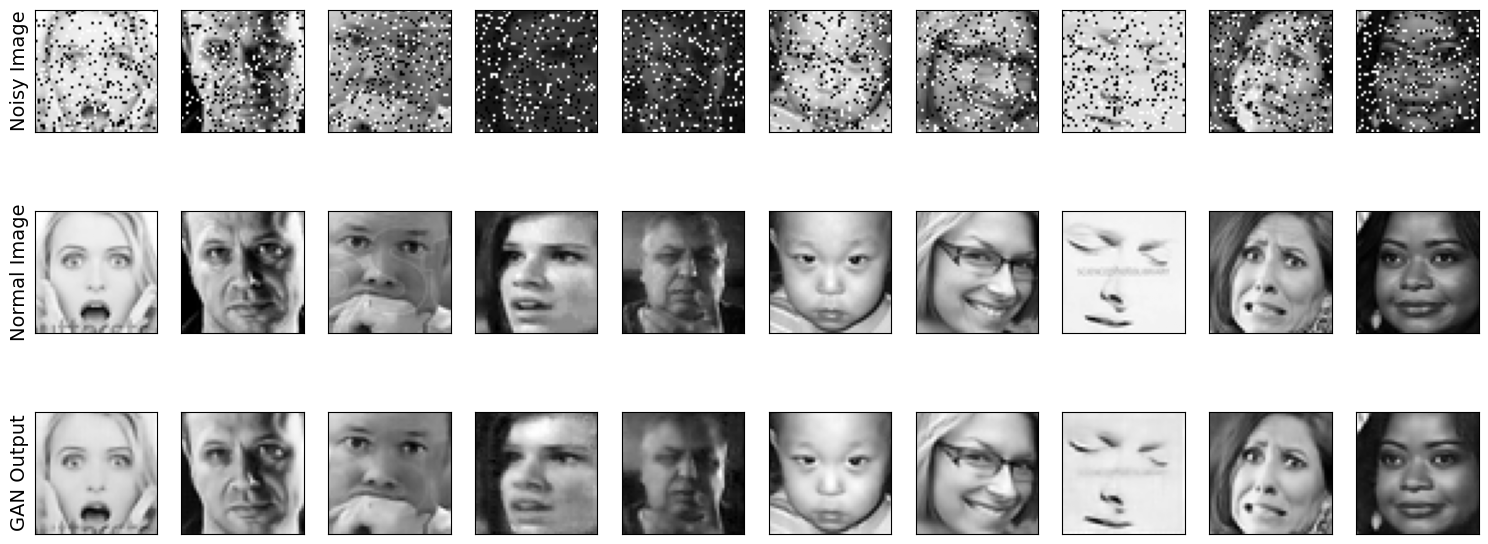

In [ ]:
def grayscale_show(img):
    if img.shape[0] == 1:  # Shape (1, H, W), single channel
        img = img.squeeze(0)  # Remove channel dimension
    elif img.shape[0] == 3:  # Shape (3, H, W), convert to grayscale
        img = img.mean(dim=0)  # Average across color channels to get grayscale

    img = img * 0.5 + 0.5  # Denormalize image from [-1, 1] to [0, 1]
    plt.imshow(img.numpy(), cmap='gray')

model.eval()
with torch.no_grad():
    noise_imgs, normal_imgs = next(iter(noisy_validation_loader))
    noise_imgs = noise_imgs.to(device)
    GAN_denoised_images = model['generator'](noise_imgs).cpu()
    noise_imgs = noise_imgs.cpu()
    normal_imgs = normal_imgs.cpu()

fig = plt.figure(1, figsize=(30, 10))

for idx in range(10):
    ax = fig.add_subplot(4, 16, idx + 1, xticks=[], yticks=[])
    if idx == 0:
        ax.set_ylabel('Noisy Image', fontsize=14)
    grayscale_show(noise_imgs[idx])

    ax = fig.add_subplot(4, 16, idx + 17, xticks=[], yticks=[])
    if idx == 0:
        ax.set_ylabel('Normal Image', fontsize=14)
    grayscale_show(normal_imgs[idx])

    ax = fig.add_subplot(4, 16, idx + 33, xticks=[], yticks=[])
    if idx == 0:
        ax.set_ylabel('GAN Output', fontsize=14)
    grayscale_show(GAN_denoised_images[idx])

In [ ]:
def calculate_ssim_psnr(output, target):
    batch_ssim = []
    batch_psnr = []

    for out, tgt in zip(output, target):
        out_np = out.squeeze(0).cpu().numpy()  # Convert to numpy (H, W)
        tgt_np = tgt.squeeze(0).cpu().numpy()  # Convert to numpy (H, W)

        out_np = (out_np * 0.5 + 0.5)
        tgt_np = (tgt_np * 0.5 + 0.5)

        ssim_value = ssim(out_np, tgt_np, data_range=tgt_np.max() - tgt_np.min(), win_size=3)
        batch_ssim.append(ssim_value)

        psnr_value = psnr(out.unsqueeze(0), tgt.unsqueeze(0), data_range=1.0)
        batch_psnr.append(psnr_value.item())

    return sum(batch_ssim) / len(batch_ssim), sum(batch_psnr) / len(batch_psnr)

def evaluate_model(model, dataloader, device):
    model.eval()
    total_ssim = 0
    total_psnr = 0
    total_images = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(dataloader, desc="Evaluating"):
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            denoised_imgs = model['generator'](noisy_imgs)

            batch_ssim, batch_psnr = calculate_ssim_psnr(denoised_imgs, clean_imgs)

            total_ssim += batch_ssim * len(noisy_imgs)  # Weight by batch size
            total_psnr += batch_psnr * len(noisy_imgs)
            total_images += len(noisy_imgs)

    avg_ssim = total_ssim / total_images
    avg_psnr = total_psnr / total_images

    return avg_ssim, avg_psnr

avg_ssim, avg_psnr = evaluate_model(model, noisy_validation_loader, device)
print(f"Final Evaluation:\nSSIM: {avg_ssim:.2f}\nPSNR: {avg_psnr:.2f}")

Evaluating:   0%|          | 0/225 [00:00<?, ?it/s]

Final Evaluation:
SSIM: 0.92
PSNR: 21.13
